# Challenges in Representation Learning: Facial Expression Recognition Challenge
### _Learn facial expressions from an image_
#### https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/overview

# 目次

1. **[プロジェクト概要](#1)**
2. **[データクリーニング](#2)**
3. **[探索的データ解析](#3)**
4. **[機械学習](#4)**
5. **[結果、まとめ](#5)**

# 1, プロジェクト概要 <a id="1"></a>

### 1.1 プロジェクトの説明
- このプロジェクトは48x48ピクセルの顔写真からその顔写真がどんな感情の顔かを識別するプロジェクトです。
- 写真は黒白写真です.
- 感情は'Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral'の7種類です。

# 2, データクリーニング <a id="2"></a>

### 2.1 データを読み込む

In [375]:
#1
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from keras import models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
#from keras.optimizers import RMSprop,Adam
from tensorflow.keras.optimizers import RMSprop
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [376]:
#2
train_df_original = pd.read_csv('kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/train.csv')
# test_df_original = pd.read_csv('kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/test.csv')
# example_submission_df_original = pd.read_csv('kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/example_submission.csv')
# icml_face_data_df_original = pd.read_csv('kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv')

In [377]:
#3
train_df = train_df_original.copy()

In [378]:
#4
train_df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


### 2.1 データを適切な値に変換する
- train_dfの'pixels'の値が '70 80 82 ...'のようになっているので[70,80,82 ...]のようにリストにしてその後そのリストを48x48x1にサイズを変換する。

In [379]:
#5
def pixels_to_array(pixels):
    array = np.array(pixels.split(),'float64')
    return array

def image_reshape(data):
    image = np.reshape(data['pixels'].to_list(),(data.shape[0],48,48,1))
    return image

In [380]:
#5
train_df['pixels'] = train_df['pixels'].apply(pixels_to_array)
X = image_reshape(train_df)
y = train_df['emotion']

In [381]:
#7
X

array([[[[ 70.],
         [ 80.],
         [ 82.],
         ...,
         [ 52.],
         [ 43.],
         [ 41.]],

        [[ 65.],
         [ 61.],
         [ 58.],
         ...,
         [ 56.],
         [ 52.],
         [ 44.]],

        [[ 50.],
         [ 43.],
         [ 54.],
         ...,
         [ 49.],
         [ 56.],
         [ 47.]],

        ...,

        [[ 91.],
         [ 65.],
         [ 42.],
         ...,
         [ 72.],
         [ 56.],
         [ 43.]],

        [[ 77.],
         [ 82.],
         [ 79.],
         ...,
         [105.],
         [ 70.],
         [ 46.]],

        [[ 77.],
         [ 72.],
         [ 84.],
         ...,
         [106.],
         [109.],
         [ 82.]]],


       [[[151.],
         [150.],
         [147.],
         ...,
         [129.],
         [140.],
         [120.]],

        [[151.],
         [149.],
         [149.],
         ...,
         [122.],
         [141.],
         [137.]],

        [[151.],
         [151.],
      

# 3, 探索的データ解析 <a id="3"></a>

### 3.1 写真の各感情の割合を確認する。

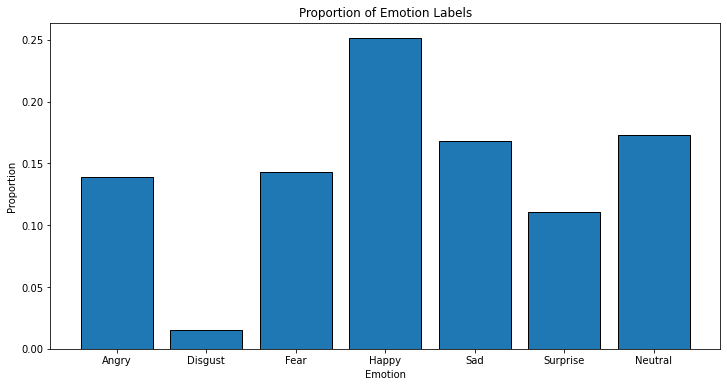

In [382]:
#8
#感情の割合のグラフを作成
emotion_prop = (train_df.emotion.value_counts() / len(train_df)).to_frame().sort_index(ascending=True)
emotions = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

plt.figure(figsize=[12,6])

plt.bar(x=emotions, height=emotion_prop['emotion'], edgecolor='black')
    
plt.xlabel('Emotion')
plt.ylabel('Proportion')
plt.title('Proportion of Emotion Labels')
plt.show()

- Happyが25%と一番多く、Disgustが2%ぐらいと極端に少ない
- モデルに'class_weight'を加えてデータ数の多いラベルの重みを軽くし、データ数の少ないラベルの重みを重くする。

In [383]:
#9
#class_weightを作成
class_weight = dict(zip(range(0, 7), (((train_df['emotion'].value_counts()).sort_index())/len(train_df['emotion'])).tolist()))
class_weight

{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

### 3.2 写真の各感情ごとに確認する

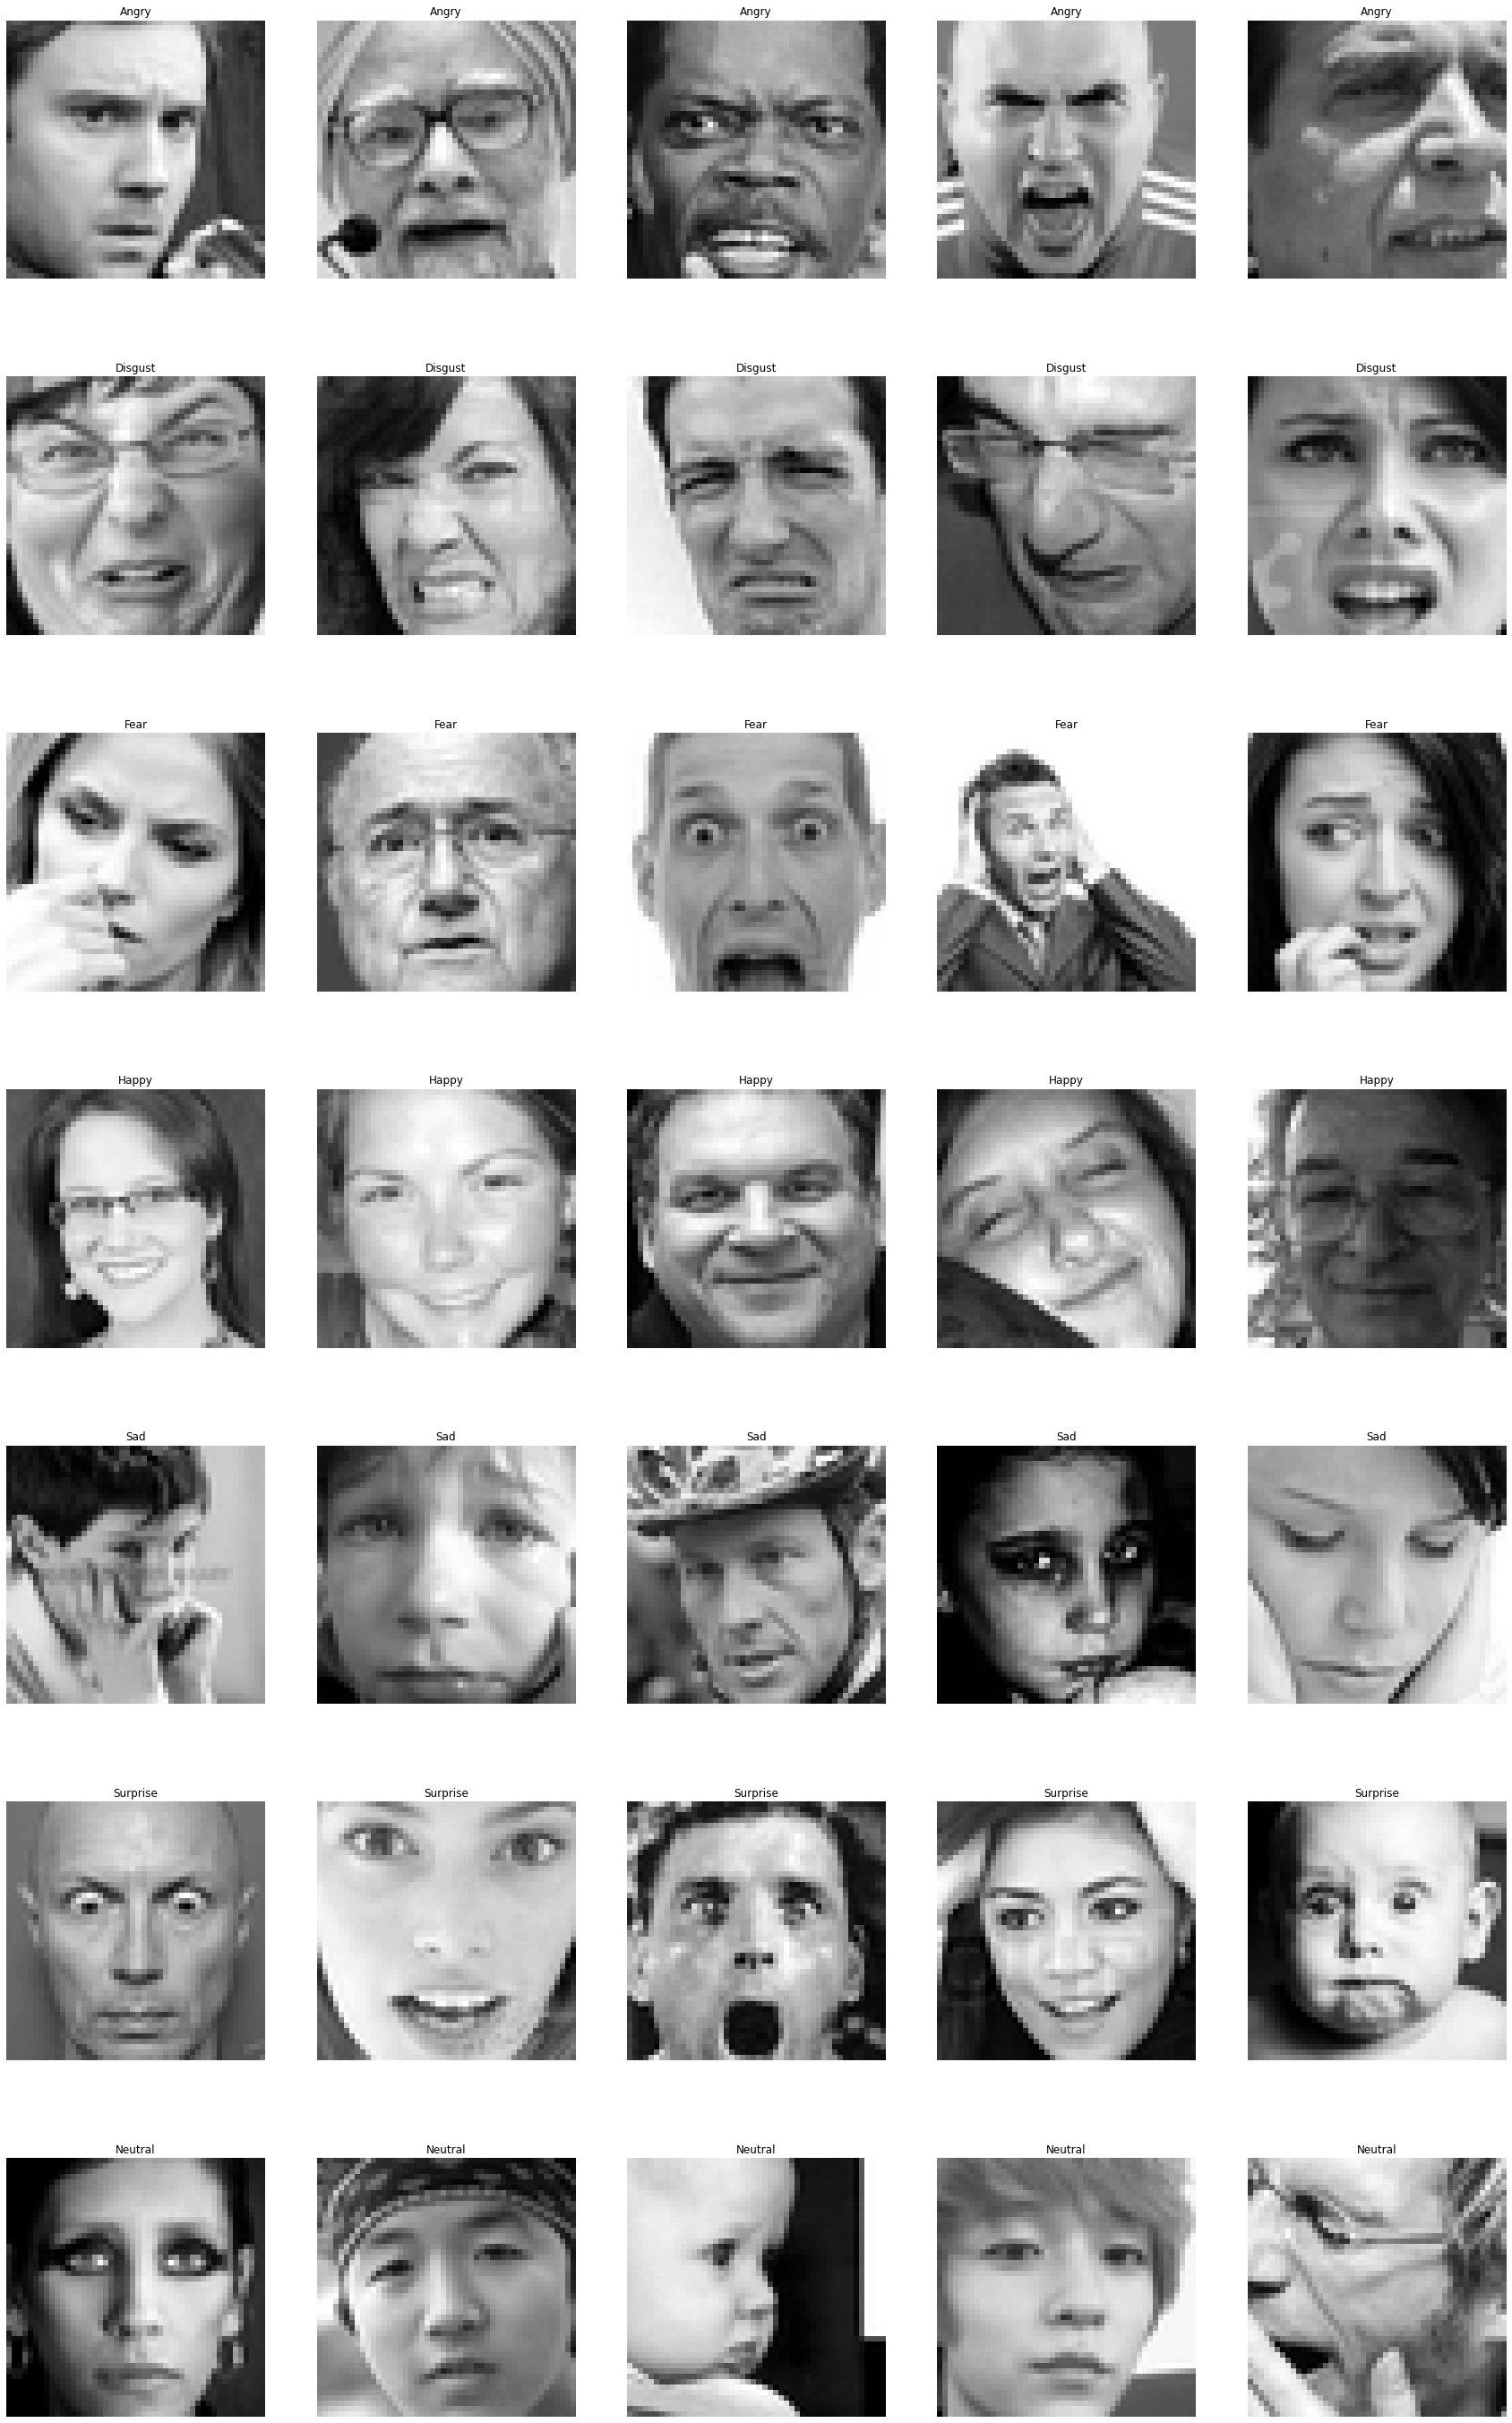

In [384]:
#10
img_ind_list = []
for i in range(7):
    img_ind_list.extend(train_df[train_df['emotion']==i][:5].index.tolist())
    
fig = plt.figure(figsize=(30,50))
for i,ind in enumerate(img_ind_list):
  ax = fig.add_subplot(7, 5, i + 1)
  ax.imshow(X[ind],cmap="gray")
  ax.set_title(emotions[y[ind]])
  ax.axis("off")
plt.show()

- これらの写真を見る限りは各感情の表情に特徴があり分類しやすいように思える。

# 5, 機械学習 <a id="5"></a>

### 5.1 データをトレインデータ、検証データ、テストデータに分ける

In [385]:
#11
X = X.astype('float32')/255

In [386]:
#12
X_train_val, X_test, y_train_val, y_test = train_test_split(X,y, random_state=0)
y_test_original = y_test.copy()
y_test = to_categorical(y_test)
y_test_categorical = to_categorical(y_test)
y_train_val = to_categorical(y_train_val)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=0)

### 5.2 モデル構築
- CNNを使ってモデルを構築する

In [387]:
#13
model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPool2D((2, 2))) #プーリング層を使い特徴をより強調させる
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='softmax'))

In [388]:
#14
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

/Users/takeshiotani/opt/anaconda3/envs/kaggle_36/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [389]:
#15
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 46, 46, 32)        320       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
flatten_13 (Flatten)         (None, 4096)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 64)              

### 5.3 モデルを学習させる

In [390]:
#16
h1 = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    class_weight = class_weight,
                    epochs=15,
                    batch_size=64)

Epoch 1/15
253/253 [==============================] - 14s 54ms/step - loss: 0.2767 - accuracy: 0.2877 - val_loss: 1.6824 - val_accuracy: 0.3623
Epoch 2/15
253/253 [==============================] - 13s 53ms/step - loss: 0.2421 - accuracy: 0.3936 - val_loss: 1.4982 - val_accuracy: 0.4332
Epoch 3/15
253/253 [==============================] - 13s 52ms/step - loss: 0.2206 - accuracy: 0.4565 - val_loss: 1.4263 - val_accuracy: 0.4672
Epoch 4/15
253/253 [==============================] - 14s 55ms/step - loss: 0.2053 - accuracy: 0.4972 - val_loss: 1.3935 - val_accuracy: 0.4746
Epoch 5/15
253/253 [==============================] - 14s 53ms/step - loss: 0.1944 - accuracy: 0.5211 - val_loss: 1.3233 - val_accuracy: 0.5116
Epoch 6/15
253/253 [==============================] - 13s 53ms/step - loss: 0.1833 - accuracy: 0.5506 - val_loss: 1.3149 - val_accuracy: 0.5190
Epoch 7/15
253/253 [==============================] - 13s 53ms/step - loss: 0.1735 - accuracy: 0.5691 - val_loss: 1.3042 - val_accuracy:

### 5.4 モデルの精度をepoch数を交えてグラフで確認する

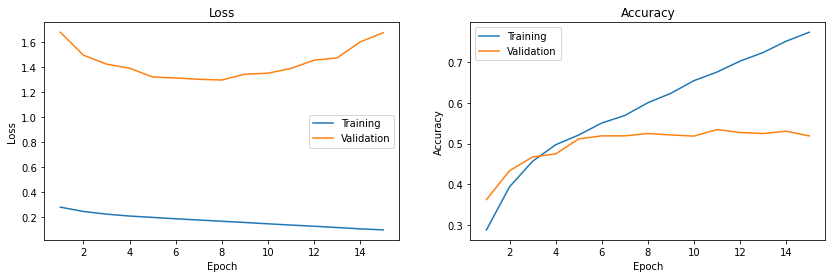

In [391]:
#17
history = h1.history

epoch_range = range(1, len(history['loss'])+1)

fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(epoch_range, history['loss'], label='Training')
ax.plot(epoch_range, history['val_loss'], label='Validation')
ax.set_xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
ax.legend()
ax = fig.add_subplot(1,2,2)
ax.plot(epoch_range, history['accuracy'], label='Training')
ax.plot(epoch_range, history['val_accuracy'], label='Validation')
ax.set_xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
ax.legend()
plt.show()

- モデルが過学習をしている

### 5.5 テストデータを使いモデルの精度を確認

In [393]:
#18
test_loss, test_acc = model.evaluate(X_test, y_test)

225/225 [==============================] - 3s 14ms/step - loss: 1.6861 - accuracy: 0.5162


- テストデータでの精度: 0.5143

### 5.6 テストデータの各感情ごとの正解率、予測している総量、予測して正解している総量、正解の数量を確認する

accuracy of Angry: 0.37
accuracy of Disgust: 0
accuracy of Fear: 0.28
accuracy of Happy: 0.82
accuracy of Sad: 0.49
accuracy of Surprise: 0.57
accuracy of Neutral: 0.43


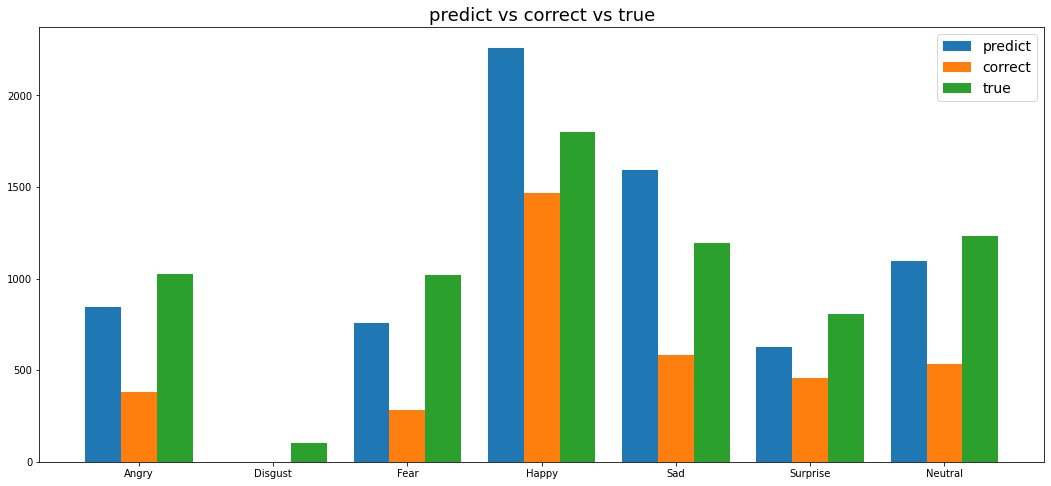

In [457]:
#19
predict_true_df = pd.DataFrame()
predict_true_df['predict'] = np.argmax(model.predict(X_test), axis = 1).tolist()
predict_true_df['true'] = np.argmax(y_test, axis = 1).tolist()
predict_true_df.head()

for i, emotion in enumerate(emotions):
    accuracy = len(predict_true_df[(predict_true_df['true']==i)&(predict_true_df['predict']==i)]) / len(predict_true_df[predict_true_df['true']==i])
    print('accuracy of {}: {:.2g}'.format(emotion,accuracy))

predict_correct = pd.DataFrame()
predict_correct['correct'] = predict_true_df[predict_true_df['true']== predict_true_df['predict']]['predict']

correct_df = predict_correct['correct'].value_counts()
predict_df = predict_true_df['predict'].value_counts()
true_df = predict_true_df['true'].value_counts()
true_predict_correct_df = pd.concat([true_df, predict_df], axis=1)
true_predict_correct_df = pd.concat([true_predict_correct_df, correct_df], axis=1).fillna(0)

plt.figure(figsize=(18,8))

x = np.array([1,2,3,4,5,6,7])
labels = emotions
 
predict = true_predict_correct_df['predict']
correct = true_predict_correct_df['correct']
true = true_predict_correct_df['true']
data = [predict,correct,true]
 
margin = 0.2  
totoal_width = 1 - margin

for i, h in enumerate(data):
  pos = x - totoal_width *( 1- (2*i+1)/len(data) )/2
  plt.bar(pos, h, width = totoal_width/len(data), label=h.name)
 
plt.title('predict vs correct vs true', fontsize=18)
plt.xticks(x, labels)
plt.legend(fontsize=14)
plt.show()

- Happy, Sadに多く予測するモデルになっている、
- Sadに多く予測しているにもかかわらず半分ぐらいしか当たってない
- Disgustは全く予想されていない

### 5.7 テストデータを使いモデルの予測がどれぐらい自信があるか(各感情の予測が何パーセントか)確認

In [481]:
#20
y_test_reset_index = y_test_original.reset_index()
y_test_reset_index = y_test_reset_index.drop('index', axis=1)
emotions_ind_list = []
for n in range(7):
    emotions_ind_list.append(y_test_reset_index[y_test_reset_index.values == n].index[0])

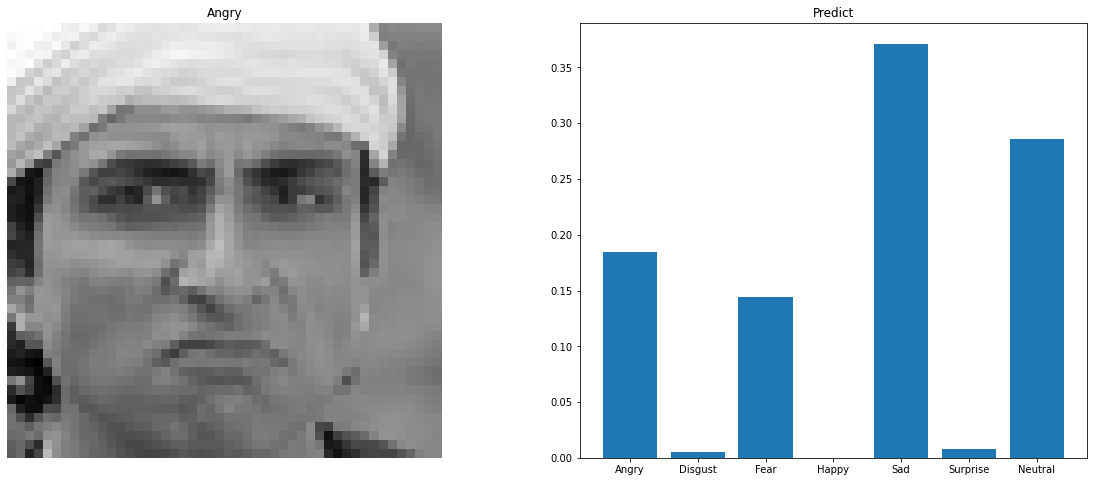

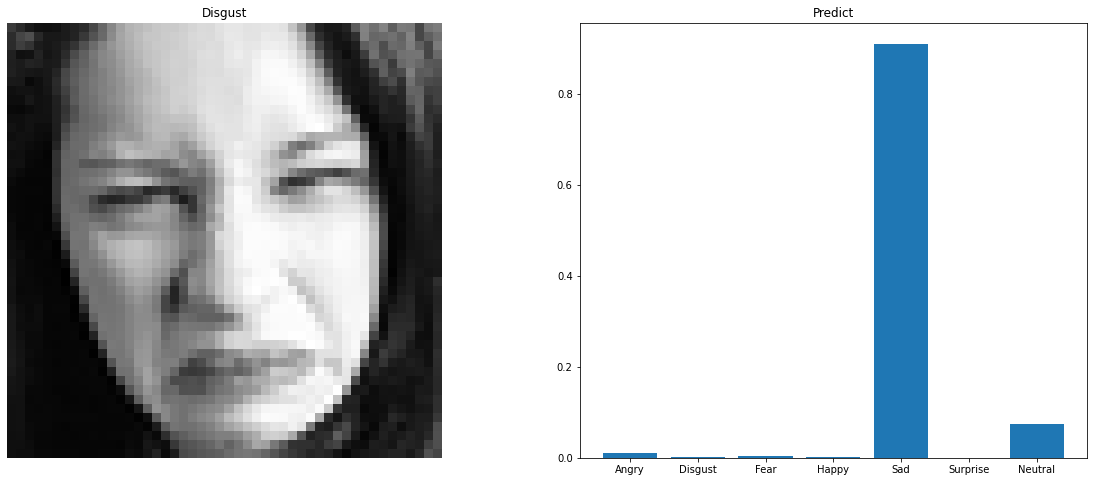

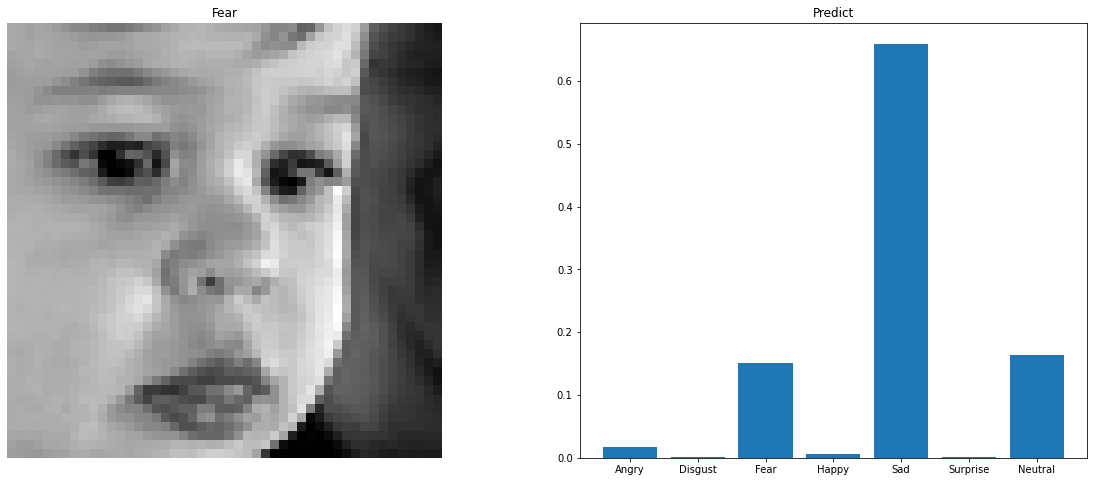

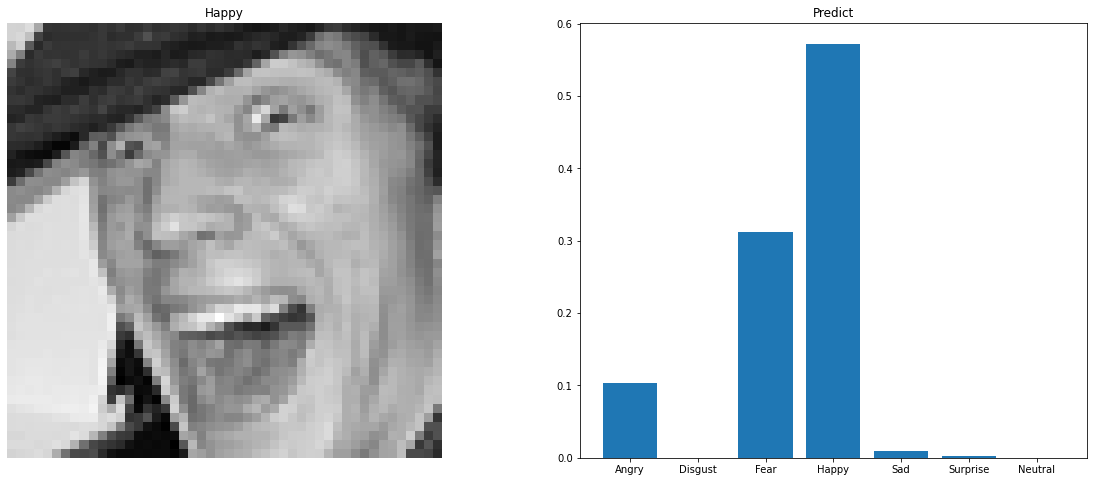

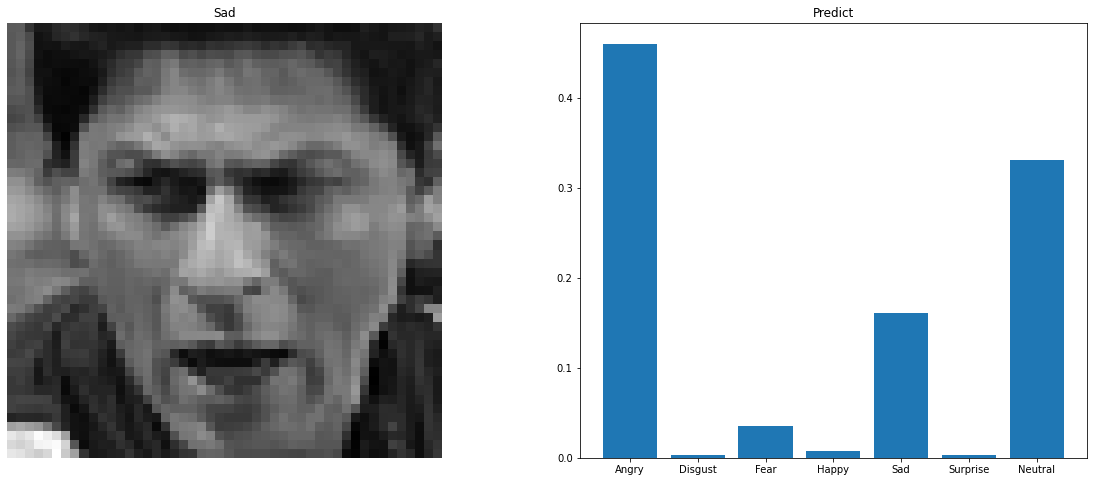

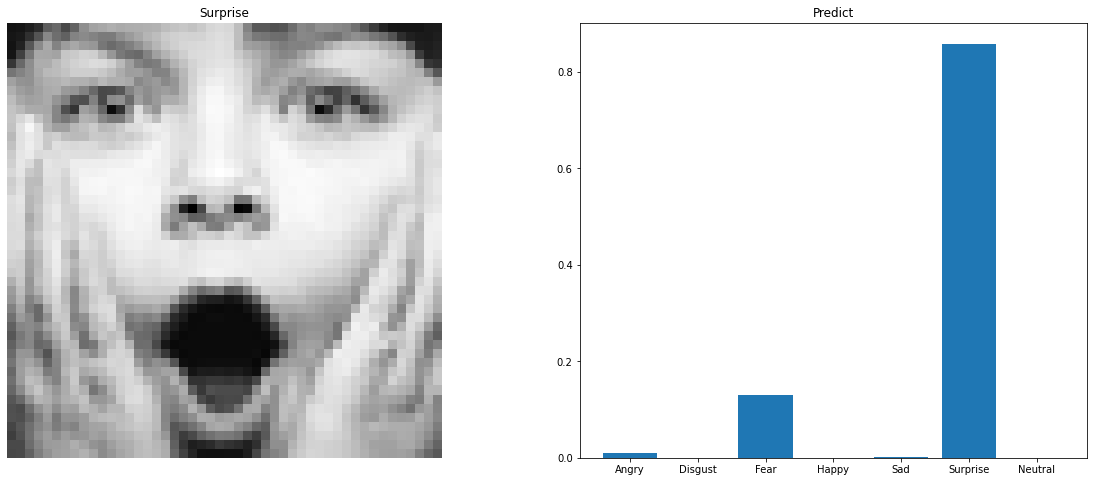

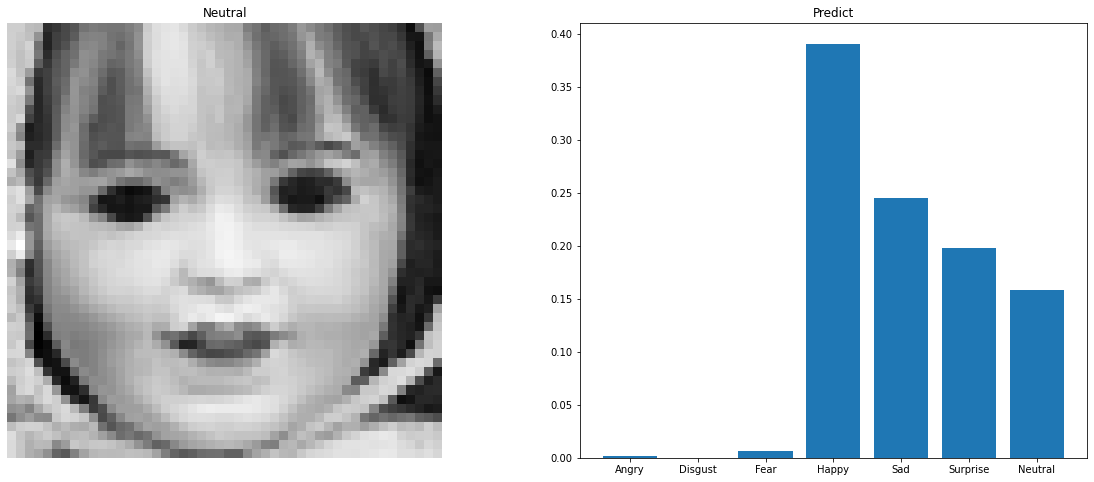

In [493]:
#21
for i, rand_ind in enumerate(emotions_ind_list):
    print
    fig = plt.figure(figsize=(20,8))
    temp = model.predict(X_test[rand_ind].reshape((1,48,48,1)))

    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(X_test[rand_ind],cmap="gray")
    ax.set_title(emotions[y_test_reset_index['emotion'][rand_ind]])
    ax.axis("off")
    ax_2 = fig.add_subplot(1, 2, 2)
    ax_2.bar(emotions, temp.tolist()[0], align="center")
    ax_2.set_title('Predict')
    plt.show()

- Happyは予測しやすいモデルになっていることが分かる
- 'Angry','Disgust','Fear','Sad'の区別があまりできていない。

# 6, 結果、まとめ <a id="6"></a>